In [4]:
import torch
import numpy as np
from utils import pack_data, unpack_1d_data, scatter_pixels

In [5]:
from diffusion import q_sample, posterior_q, Denoising, denoise_with_mu

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## ATTENTION ##
###### Download this image https://www.infomoney.com.br/wp-content/uploads/2019/06/homer-simpson.jpg?resize=900%2C515&quality=50&strip=all and save it in this folder as 'homer.png'


In [7]:
x,y = scatter_pixels('homer.jpg')
x = [x/25 -3 for x in x]
y = [y/25 -2 for y in y]

## Scatter plot of data we will try to train the model to generate from random noise

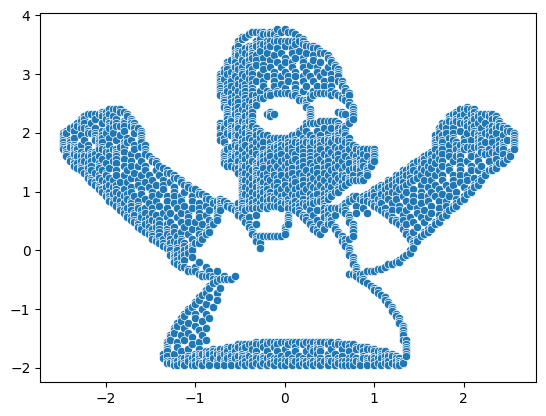

In [12]:
import seaborn as sns
ax = sns.scatterplot(x=x,y=y)   

In [13]:
## Store the ax to plot the result later
y_ax = ax.get_ylim()
x_ax = ax.get_xlim()
axes = (x_ax,y_ax)

In [14]:
# send data to device
one_d_data = pack_data(x,y)
x_init = torch.tensor(one_d_data).to(torch.float32).to(device)

DATA_SIZE = len(x_init)


# Diffusion Parameters

In [15]:
beta_start = .0004
beta_end = .02
num_diffusion_timesteps = 30

In [16]:
from operator import mul
from functools import reduce 

betas = np.linspace(beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps) ** 2
alphas = 1 - betas

# send parameters to device
betas = torch.tensor(betas).to(torch.float32).to(device)
alphas = torch.tensor(alphas).to(torch.float32).to(device)

# alpha_bar_t is the product of all alpha_ts from 0 to t
list_bar_alphas = [alphas[0]]
for t in range(1,num_diffusion_timesteps):
    list_bar_alphas.append(reduce(mul,alphas[:t]))
    
list_bar_alphas = torch.cumprod(alphas, axis=0).to(torch.float32).to(device)

## Training Procedure

In [17]:
import torch.nn as nn
import torch.optim as optim


training_steps_per_epoch = 40


criterion = nn.MSELoss()
denoising_model = Denoising(DATA_SIZE, num_diffusion_timesteps).to(device)
# disgusting hack to put embedding layer on 'device' as well, as it is not a pytorch module!
denoising_model.emb = denoising_model.emb.to(device)
optimizer = optim.AdamW(denoising_model.parameters())

In [19]:
from tqdm import tqdm

pbar = tqdm(range(50))
for epoch in pbar:  # loop over the dataset multiple times
    
    running_loss = 0.0
    # sample a bunch of timesteps
    Ts = np.random.randint(1,num_diffusion_timesteps, size=training_steps_per_epoch)
    for _, t in enumerate(Ts):
        # produce corrupted sample
        q_t = q_sample(x_init, t, list_bar_alphas, device)
                
        # calculate the mean and variance of the posterior forward distribution q(x_t-1 | x_t,x_0)
        mu_t, cov_t = posterior_q(x_init, q_t, t, alphas, list_bar_alphas, device)
        # get just first element from diagonal of covariance since they are all equal
        sigma_t = cov_t[0][0]
        # zero the parameter gradients
        optimizer.zero_grad()
  
        mu_theta = denoising_model(q_t , t)
        loss = criterion(mu_t, mu_theta)
        loss.backward()
        optimizer.step()
        running_loss += loss.detach()
    pbar.set_description('Epoch: {} Loss: {}'.format(epoch, running_loss/training_steps_per_epoch))
print('Finished Training')

  0%|          | 0/50 [00:00<?, ?it/s]

: 

: 

### Reserve-Diffuse one Sample of Noise!

In [20]:
from tqdm import tqdm 
data = torch.distributions.MultivariateNormal(loc=torch.zeros(DATA_SIZE),covariance_matrix=torch.eye(DATA_SIZE)).sample().to(device)

for t in tqdm(range(0,num_diffusion_timesteps)):
    data = denoise_with_mu(denoising_model,data,num_diffusion_timesteps-t-1, alphas, list_bar_alphas, DATA_SIZE, device)

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.97it/s]


/home/lira/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

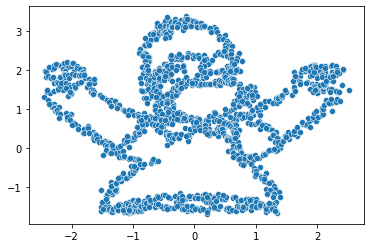

In [21]:
data = data.detach().cpu().numpy()
x_new, y_new = unpack_1d_data(data)

import seaborn as sns
sns.scatterplot(x_new,y_new)

### Create an AWESOME HD 24fps GIF

MovieWriter ffmpeg unavailable; using Pillow instead.


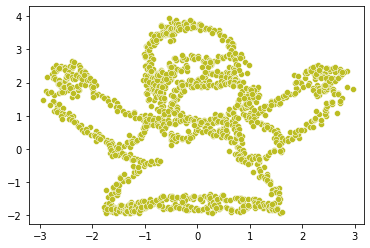

In [31]:
import numpy as np
from celluloid import Camera
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
camera = Camera(fig)

# animation draws one data point at a time
for d in range(1, num_diffusion_timesteps):
    data = denoise_with_mu(denoising_model,data,num_diffusion_timesteps-d, alphas, list_bar_alphas, DATA_SIZE, device)
    data_plot = data.detach().cpu().numpy()
    x_new, y_new = unpack_1d_data(data_plot)
    graph = sns.scatterplot(x=x_new,y=y_new,palette=['green'])
    graph.set_xlim(axes[0])
    graph.set_ylim(axes[1])
    camera.snap()

anim = camera.animate(blit=False)
anim.save('output.gif',fps=24, dpi=120)